# Preparation

In [1]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

In [2]:
DATASET_PATH = "/kaggle/input/snooker-balls/balls"
OUTPUT_PATH = "/kaggle/working"

# Dataset 

### Original Dataset Structure
Dataset structure is given in next format:
```
snooker-balls/balls/
    train/
        {class1}/
            {id_1}.jpg
            {id_2}.jpg
            ...
        {class2}/
            ...
        ...
    test/
    ...
```

### Yolo Dataset Structure
Dataset structure should be transformed to next format:
```
yolo_dataset/
    images/
        train/
            {class1}_{id_1}.jpg
            {class1}_{id_2}.jpg
            ...
        val/
            ...
    labels/
        train/
            {class1}_{id_1}.txt
            {class1}_{id_2}.txt
            ...
        val/
            ...
```

In [3]:
# root directory to save dataset in yolo format
root_dir=os.path.join(OUTPUT_PATH,"yolo_dataset")
os.makedirs(root_dir, exist_ok=True)

# train and test subdirectories with image directory
images_dir=os.path.join(root_dir,"images")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(images_dir+"/train", exist_ok=True)
os.makedirs(images_dir+"/val", exist_ok=True)

# train and test subdirectories with label directory
labels_dir=os.path.join(root_dir,"labels")
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(labels_dir+"/train", exist_ok=True)
os.makedirs(labels_dir+"/val", exist_ok=True)

In [4]:
# variables to convert label/id to id/label
label2id = {"black": 0, "blue": 1, "brown": 2, "green": 3, "pink": 4, "red": 5, "white": 6, "yellow": 7}
id2label = {v: k for k, v in label2id.items()}

In [5]:
for layer1 in os.listdir(DATASET_PATH):
    for layer2 in os.listdir(f'{DATASET_PATH}/{layer1}'):
        for layer3 in os.listdir(f'{DATASET_PATH}/{layer1}/{layer2}'):
            if layer3.endswith('.jpg'):
                shutil.copyfile(f'{DATASET_PATH}/{layer1}/{layer2}/{layer3}',f'{images_dir}/{layer1}/{layer2}_{layer3}'.replace('test', 'val' ))
                f = open(f'{labels_dir}/{layer1}/{layer2}_{layer3}'[:-4].replace('test', 'val' )+'.txt', 'w')
                f.write(str(label2id[layer2])+' 0.5 0.5 1 1')
                f.close()

# YOLOv8

In [6]:
!pip install ultralytics
!yolo checks
from ultralytics import YOLO

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/28/76/3f4ba6c345461cbf79fb45828cdc42b15f60b65a3474e35ad6f476d1d4c7/ultralytics-8.0.230-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 23.3 MB/s eta 0:00:00
Ultralytics YOLOv8.0.230 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5310.5/8062.4 GB disk)

OS                  Linux-5.15.133+-x86_64-with-glibc2.31
Environment         Kaggle
Python              3.10.12
Install             pip
RAM                 31.36 GB
CPU                 AMD EPYC 7B12
CUDA                None

matplotlib          ✅ 3.7.4>=3.3.0
numpy               ✅ 1.24.3>=1.22.2
opencv-python       ✅ 4.8.1.78>=4.6.0
pillow              ✅ 9.5.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.0.0+cpu>=1.8.0
torchvision         ✅ 0.15.1+cpu>=0.9.0
tqdm       

### Convert Dataset to Yolo Format

In [7]:
names_content = "\n".join([f"  {label_id}: {label}" for label, label_id in label2id.items()])
dataset_content = f"""
path: "{root_dir}/"
train: "images/train"
val: "images/val"
test: "images/val"
names:
{names_content}
"""
with open(os.path.join(OUTPUT_PATH, "custom_dataset.yaml"), "w") as f:
    f.write(dataset_content)

### Train the Model

In [9]:
# pretrained model: yolov8n、yolov8s、yolov8m、yolov8l、yolov8x
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

# Train the model using the processed dataset
results = model.train(
    data=os.path.join(OUTPUT_PATH,'custom_dataset.yaml'),
    project='snooker_project',
    epochs=50,
    batch=64,
    imgsz=16,
    nbs=64,
    val=True,
    optimizer='Adam',
    lr0=0.001,
    lrf=0.0005
)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 11510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11510/11510 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 2873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2873/2873 [00:00<?, ?it/s]

Plotting labels to snooker_project/train2/labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
WARNING ⚠️ TensorBoard graph visualization failure Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       0.87      1.603      1.034        165         32: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]


                   all       2873       2873      0.571      0.702      0.506      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.6068     0.9804     0.9779        189         32:   8%|▊         | 14/180 [00:03<00:47,  3.52it/s]wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'train/box_loss': 0.87002, 'train/cls_loss': 1.60282, 'train/dfl_loss': 1.03351, '_timestamp': 1703775690.0451488}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'lr/pg0': 0.06718333333333334, 'lr/pg1': 0.0003314814814814815, 'lr/pg2': 0.0003314814814814815, '_timestamp': 1703775690.0455704}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'metrics/precision(B)': 0.57083, 'metrics/recall(B)': 0.702, 'metrics/mAP50(B)': 0.5065, 'metrics/mAP50-95(B)': 0.45871, 'val/box_loss': 0.62057, 'val/cls_loss': 5.89819, 'val/dfl_loss': 1.07288, '_timestamp': 1

                   all       2873       2873      0.664      0.833      0.761      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.4933     0.6331     0.9399        164         32: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.49it/s]


                   all       2873       2873      0.669      0.863       0.87      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.4458       0.55     0.9263        166         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


                   all       2873       2873      0.846      0.738      0.957      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      0.408     0.5079     0.9212        162         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]


                   all       2873       2873      0.759        0.6      0.922      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      0.378     0.4591     0.9177        165         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


                   all       2873       2873      0.931      0.809      0.929      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.3708     0.4487     0.9117        174         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.63it/s]


                   all       2873       2873      0.955      0.827      0.985      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.3603     0.4212     0.9106        176         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]


                   all       2873       2873      0.718      0.968      0.919      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.3505     0.4083     0.9101        153         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


                   all       2873       2873      0.936      0.938      0.969      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.3431     0.4016       0.91        175         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]


                   all       2873       2873      0.965      0.954      0.986      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.3354     0.3868     0.9082        163         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


                   all       2873       2873      0.896       0.97      0.977       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.3227     0.3782     0.9071        171         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]


                   all       2873       2873      0.895      0.921      0.988       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      0.316     0.3655     0.9055        172         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]


                   all       2873       2873       0.95      0.929      0.977      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.3079     0.3552     0.9059        173         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]


                   all       2873       2873       0.94      0.932       0.99      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.3052     0.3529     0.9046        176         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]


                   all       2873       2873      0.795      0.901      0.981      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.3051     0.3551     0.9039        158         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]


                   all       2873       2873      0.796      0.869      0.947      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.2971      0.348     0.9032        163         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


                   all       2873       2873      0.884       0.88      0.992      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.2951     0.3381     0.9047        157         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.71it/s]


                   all       2873       2873      0.865      0.914      0.982      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.2849     0.3335     0.9039        171         32: 100%|██████████| 180/180 [00:50<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]


                   all       2873       2873      0.906      0.953      0.991      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.2831     0.3218     0.9015        168         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


                   all       2873       2873      0.743      0.774      0.873      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.2851     0.3294     0.9013        151         32: 100%|██████████| 180/180 [00:49<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]


                   all       2873       2873      0.804      0.778      0.933      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.2723     0.3206     0.9003        182         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]


                   all       2873       2873      0.729      0.806      0.939      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      0.273     0.3177     0.9015        149         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.71it/s]


                   all       2873       2873      0.938      0.916      0.988      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.2663     0.3105     0.8993        169         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


                   all       2873       2873       0.96      0.972       0.99      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.2621     0.3101     0.9003        161         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


                   all       2873       2873      0.963      0.944       0.99      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.2637     0.3075     0.9003        175         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]


                   all       2873       2873      0.901      0.939      0.989      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.2599     0.3015     0.8999        170         32: 100%|██████████| 180/180 [00:49<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.38it/s]


                   all       2873       2873      0.824      0.924      0.974      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.2532     0.2982     0.8992        169         32: 100%|██████████| 180/180 [00:49<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]


                   all       2873       2873      0.847      0.795      0.792       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.2545     0.2983     0.8997        159         32: 100%|██████████| 180/180 [00:49<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


                   all       2873       2873      0.947      0.945       0.99      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.2487     0.2884     0.9005        157         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


                   all       2873       2873      0.707      0.825      0.791      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.2452     0.2885     0.8985        172         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


                   all       2873       2873      0.986      0.984       0.99      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.2359     0.2799     0.8985        161         32: 100%|██████████| 180/180 [00:50<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.46it/s]


                   all       2873       2873      0.598      0.681      0.681      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.2427     0.2822     0.8992        164         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.73it/s]


                   all       2873       2873      0.921      0.762      0.883      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.2386      0.278     0.8975        167         32: 100%|██████████| 180/180 [00:49<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


                   all       2873       2873      0.902      0.936      0.981       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.2318     0.2735     0.8984        166         32: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


                   all       2873       2873       0.93      0.927      0.986      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.2317     0.2667     0.8989        170         32: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


                   all       2873       2873      0.688      0.782      0.872      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.2265     0.2687     0.8966        170         32: 100%|██████████| 180/180 [00:50<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]


                   all       2873       2873      0.936      0.721      0.969      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.2212     0.2609     0.8979        171         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]


                   all       2873       2873      0.732      0.738      0.674      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.2219     0.2564     0.8985        166         32: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]


                   all       2873       2873      0.733      0.922      0.976      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.2168      0.253     0.8969        166         32: 100%|██████████| 180/180 [00:50<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


                   all       2873       2873      0.794      0.846      0.954      0.839
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.1774     0.2142     0.9094         54         32: 100%|██████████| 180/180 [00:41<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]


                   all       2873       2873      0.908      0.991       0.98      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.1539     0.1575     0.9081         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


                   all       2873       2873      0.686      0.963      0.927       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.1465     0.1476     0.9077         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.71it/s]


                   all       2873       2873      0.882       0.98      0.961      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.1449     0.1387     0.9033         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]


                   all       2873       2873      0.805      0.983      0.946      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.1396     0.1315     0.9023         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]


                   all       2873       2873      0.845      0.965      0.947      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.1386     0.1285     0.9011         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


                   all       2873       2873      0.843      0.971      0.955       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.1348     0.1248      0.902         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.73it/s]


                   all       2873       2873      0.826      0.985      0.956      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.1319     0.1183     0.8998         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]


                   all       2873       2873      0.834      0.975      0.957      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.1281     0.1144     0.9008         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.73it/s]


                   all       2873       2873      0.829      0.983      0.955      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.1269     0.1118      0.903         54         32: 100%|██████████| 180/180 [00:40<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


                   all       2873       2873      0.824      0.988      0.967      0.912

50 epochs completed in 0.771 hours.
Optimizer stripped from snooker_project/train2/weights/last.pt, 6.2MB
Optimizer stripped from snooker_project/train2/weights/best.pt, 6.2MB

Validating snooker_project/train2/weights/best.pt...
Ultralytics YOLOv8.0.230 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


                   all       2873       2873      0.906      0.954      0.991      0.959
                 black       2873        359          1       0.88      0.982      0.957
                  blue       2873        323      0.434          1      0.988      0.986
                 brown       2873        331          1      0.821       0.99      0.919
                 green       2873        239      0.984          1      0.995      0.995
                  pink       2873         42      0.884          1      0.995      0.914
                   red       2873        322      0.979      0.935      0.989      0.983
                 white       2873       1233      0.997      0.994      0.995       0.92
                yellow       2873         24      0.969          1      0.995      0.995
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to snooker_project/train2


lr/pg0,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▆▇▇█▇█████▇███▇▇████▅██▄▆█▆█▃██▇█▇▇▇▇█
metrics/mAP50-95(B),▁▅▆▇▇█▆█▇█▇█▇█▇█▆▆██▇█▅▆▇▃▅▇▅▆▂▇▇▆▇▆▇▇▇█
metrics/precision(B),▁▃▃▆▇▇▃▇▆▆▇▇▅▆▆▇▅▄▇█▇▅▆▇█▁▇▇▃▇▄▄▇▃▆▅▆▅▅▇
metrics/recall(B),▁▄▅▂▄▄▇▇█▆▇▇▅▆▆▇▃▄▆█▇▆▄▇█▁▃▇▃▂▂▆█▇█████▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


### Validate the Model

In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

### Export the Model with **ONNX**

In [ ]:
model.export(format='onnx')

### Benchmark the Model with **ONNX**

In [ ]:
from ultralytics.utils.benchmarks import benchmark
benchmark(model='snooker_project/train2/weights/best.pt', imgsz=128)

### Create a Download Link

In [ ]:
%cd $OUTPUT_PATH
!zip -r snooker_project.zip snooker_project
from IPython.display import FileLink
FileLink(r'snooker_project.zip')

# TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ultralytics/runs

# Track the Image

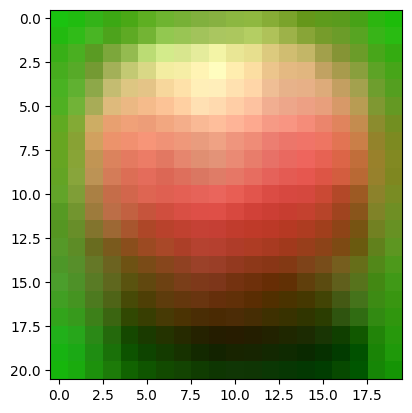

In [25]:
plt.imshow(cv2.cvtColor(cv2.imread('/kaggle/working/yolo_dataset/images/val/pink_ball_518.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
results = model('/kaggle/working/yolo_dataset/images/val/pink_ball_518.jpg', save=True)


image 1/1 /kaggle/working/yolo_dataset/images/val/pink_ball_518.jpg: 32x32 1 pink, 8.6ms
Speed: 0.3ms preprocess, 8.6ms inference, 0.6ms postprocess per image at shape (1, 3, 32, 32)
Results saved to snooker_project/train24


In [32]:
from PIL import Image
for r in results:
    im_array = r.plot()  # 绘制包含预测结果的BGR numpy数组
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL图像
    im.show()  # 显示图像
    #im.save('results.jpg')

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmps8gq5fqf.PNG'


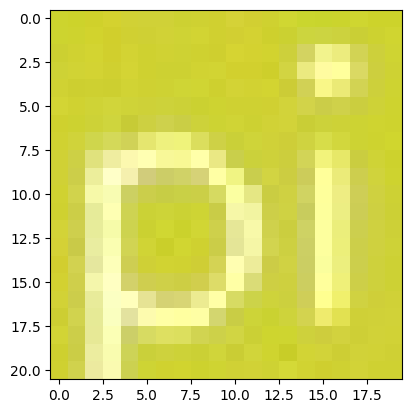

In [33]:
plt.imshow(cv2.cvtColor(cv2.imread('/kaggle/working/snooker_project/train23/pink_ball_518.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

# Video with PyTube

In [10]:
!pip install pytube
from pytube import YouTube
YouTube('https://youtu.be/hw02UKK4Kb0').streams.filter().get_highest_resolution().download(output_path=OUTPUT_PATH, filename='youtube.mp4')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.5 MB/s eta 0:00:00


'/kaggle/working/youtube.mp4'

In [11]:
%cd $OUTPUT_PATH
!ffmpeg -i youtube.mp4 -vcodec copy -acodec copy -ss 00:01:05 -to 00:01:15 video.mp4 -y

/kaggle/working
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

In [14]:
%cd $OUTPUT_PATH
Video('video.mp4', width=840)

/kaggle/working


# Predict the Video

In [15]:
%cd $OUTPUT_PATH
video_model = YOLO("snooker_project/train2/weights/best.pt")
video_model.predict(source="video.mp4", show=False, save=True)

/kaggle/working


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/226) /kaggle/working/video.mp4: 32x32 3 blacks, 10.1ms
video 1/1 (2/226) /kaggle/working/video.mp4: 32x32 2 blacks, 6.3ms
video 1/1 (3/226) /kaggle/working/video.mp4: 32x32 2 blacks, 6.0ms
video 1/1 (4/226) /kaggle/working/video.mp4: 32x32 2 blacks, 1 brown, 5.5ms
video 1/1 (5/226) /kaggle/working/video.mp4: 32x32 2 blacks, 5.5ms
video 1/1 (6/226) /kaggle/working/video.mp4: 32x32 3 blacks, 1 brown, 6.7ms
video 1/1 (7/226) /

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        ...,
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
         [90, 96, 91],
         [90, 96, 91]],
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
       

In [17]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/predict/video.avi predict_video.mp4
# Display the video 
Video("predict_video.mp4", width=600)

/kaggle/working


# Track the Video with **ByteTrack**

In [ ]:
%cd $OUTPUT_PATH
videl_model = YOLO('snooker_project/train2/weights/best.pt')
videl_model.track(source="video.mp4", tracker="bytetrack.yaml", save=True)

In [ ]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/predict2/video.avi track_video.mp4
# Display the video 
Video("track_video.mp4", width=840)